# Algorytmy macierzowe - zadanie nr 5 - Algorytmy permutacji macierzy rzadkich

"Proszę zbudować graf eliminacji dla macierzy rzadkiej używanej w zadaniu 4
(rzadka eliminacja) (bazując na swoim formacie macierzy rzadkiej z zadania 4.

Proszę napisać wybrany algorytm permutacji macierzy na swojej macierzy
rzadkiej:
1. Minimum degree
2. Cuthill-McKee
3. Nested-dissections

Proszę porównać czasy działania rzadkiej eliminacji Gaussa przed i po
permutacji macierzy"

Marcin Hawryluk, Norbert Wolniak <br>grupa: piątek 12:50B <hr>

In [1]:
import numpy as np
import networkx as nx
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import os
from time import time
from matrix_functions import read_matrix, convert_to_csr

## Generowanie macierzy

In [2]:
matrix_3a = read_matrix('matrices/3a.txt')
matrix_4a = read_matrix('matrices/3a.txt')

## Eliminacja Cholesky'ego

In [3]:
def sparse_cholesky(matrix):
    '''
        returns L.T matrix in CSR format
        that (L.T.)T @ L.T == matrix
    '''

    ICL = matrix[0][:]
    VAL = matrix[1][:]
    ROWPTR = matrix[2][:]
    
    n = len(ROWPTR) - 1
    
    def get_col_in_row(row, col):
        '''binary search for an index of value col in array row
            if col not in row returns index of the first bigger value than col
            if every value in row is smaller than col then returns None'''
        start = 0
        end = len(row)-1

        while start < end:
            middle = (start+end)//2
            if row[middle] < col:
                start = middle+1
            else:
                end = middle

        if row[start] == col:
            return start
        else:
            if start + 1 < len(row):
                return start + 1
            return None

    for k in range(n):
        row_start = ROWPTR[k]
        row_end = ROWPTR[k+1]

        if ICL[row_start] != k or VAL[row_start] < 0:
            raise Exception('nonpositive value on diagonal')

        VAL[row_start] **= 0.5
        dkk = VAL[row_start]

        # last row -> nothing to eliminate
        if k == n-1:
            break

        for j in range(row_start+ 1, row_end):
            VAL[j] /= dkk

        # new arrays for ICL, VAL, ROWPTR
        # starting with part of the matrix that won't be eliminated
        # later we're adding all other values after each elimination step
        new_icl = ICL[:row_end]
        new_val = VAL[:row_end]
        new_rowptr = ROWPTR[:k+2]

        vk_index = row_start + 1

        for j in range(k+1, n):
            # top_row = kth_row (not always 0th row!)
            # j_row = jth_row
            # we aim to calculate:  j_row = j_row - top_row*vk
            j_row_start = ROWPTR[j]
            j_row_end = ROWPTR[j+1]

            # we find indices in top_row ICL and j_row ICL on which value j is,
            # so we can start eliminating from there
            j_index_j_row = get_col_in_row(ICL[j_row_start:j_row_end], j)
            j_index_top_row = get_col_in_row(ICL[row_start:row_end], j)

            # if vk is 0, we just copy j_row from jth index and continue to the next row
            if vk_index >= row_end or ICL[vk_index] != j:
                if j_index_j_row is not None:
                    new_icl += ICL[j_row_start+j_index_j_row:j_row_end]
                    new_val += VAL[j_row_start+j_index_j_row:j_row_end]

                new_rowptr.append(len(new_icl))
                continue

            vk = VAL[vk_index]

            # if both top row and jth row are empty after jth index, we move onto the next row
            if j_index_j_row is None and j_index_top_row is None:
                new_rowptr.append(len(new_icl))
                continue

            # if jth row is empty after jth index we copy -vk*top_row
            if j_index_j_row is None:
                new_icl += ICL[row_start + j_index_top_row:row_end]
                new_val += [-vk*x for x in VAL[row_start +
                                               j_index_top_row:row_end]]
                new_rowptr.append(len(new_icl))
                continue
            else:
                 j_row_index = j_row_start + j_index_j_row

            # if top row is empty after jth index we just copy jth row as it is
            if j_index_top_row is None:
                new_icl += ICL[j_row_index:j_row_end]
                new_val += VAL[j_row_index:j_row_end]
                new_rowptr.append(len(new_icl))
                continue
            else:
                top_row_index = row_start + j_index_top_row


            # we iterate through top_row and j_row at the same time
            # doing the elimination
            # new non-zero values may occur
            while j_row_index < j_row_end and top_row_index < row_end:
                top_col = ICL[top_row_index]
                j_col = ICL[j_row_index]

                # nonzero value in kth row, zero in jth
                # new nonzero value
                if top_col < j_col:
                    val = -vk*VAL[top_row_index]
                    if abs(val) > 1e-8:
                        new_icl.append(top_col)
                        new_val.append(val)
                    top_row_index += 1

                # both values nonzero
                elif top_col == j_col:
                    val = VAL[j_row_index]-vk*VAL[top_row_index]
                    if abs(val) > 1e-8:
                        new_icl.append(top_col)
                        new_val.append(val)

                    top_row_index += 1
                    j_row_index += 1

                # nonzero in jth row, but zero in k
                elif top_col > j_col:
                    new_icl.append(j_col)
                    new_val.append(VAL[j_row_index])
                    j_row_index += 1

            # there might still be nonzero values in jth row
            # and just zeros in kth
            while j_row_index < j_row_end:
                new_icl.append(ICL[j_row_index])
                new_val.append(VAL[j_row_index])
                j_row_index += 1

            # there might still be nonzero values in kth row
            # and just zeros in jth
            while top_row_index < row_end:
                val = -vk*VAL[top_row_index]
                if abs(val) > 1e-8:
                    new_icl.append(ICL[top_row_index])
                    new_val.append(val)
                top_row_index += 1

            new_rowptr.append(len(new_icl))

            if vk_index < row_end and ICL[vk_index] == j:
                vk_index += 1

        ICL = new_icl
        ROWPTR = new_rowptr
        VAL = new_val

    return ICL, VAL, ROWPTR

## Graf eliminacji

In [4]:
def elimination_graph_dense(matrix):
    graph = nx.Graph()
    
    n, m = matrix.shape
    
    for i in range(n):
        for j in range(i, m):
            if abs(matrix[i, j]) > 1e-8:
                graph.add_edge(i, j)
    
    return graph    

In [9]:
def elimination_graph_csr(matrix):
    graph = nx.Graph()
    
    ICL, VAL, ROWPTR = matrix
    n = len(ROWPTR) - 1
    matrix = np.zeros((n, n))

    graph.add_nodes_from([x for x in range(n)])
    for row in range(n):
        for j in range(ROWPTR[row], ROWPTR[row+1]):
            if row == ICL[j]:continue
            graph.add_edge(row, ICL[j])
            
    return graph

In [10]:
def draw_graph(graph, pos=None, node_size=400, figsize=(10,10)):
    if pos is None:
        pos = nx.random_layout(graph)
        
    plt.figure(figsize=figsize)
    nx.draw(graph, pos=pos, with_labels=True, node_size=node_size, node_color='lightblue', edge_color='silver')

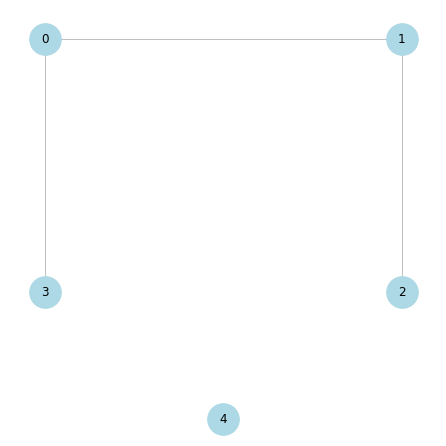

In [11]:
test_matrix = np.array([
    [1, 1, 0, 1, 0],
    [1, 2, 1, 0, 0],
    [0, 1, 3, 0, 0],
    [1, 0, 0, 4, 0],
    [0, 0, 0, 0, 5],
])

test_pos = {
    0: (0, 1),
    1: (1, 1),
    2: (1, 0),
    3: (0, 0),
    4: (0.5, -0.5)
}
draw_graph(elimination_graph_csr(convert_to_csr(test_matrix)), test_pos, 1000, (6, 6))

"2a. Dla podmacierzy o rozmiarze <= 100 np. A[1:100][1:100] wierszy proszę
zbudować i narysować graf eliminacji G0"

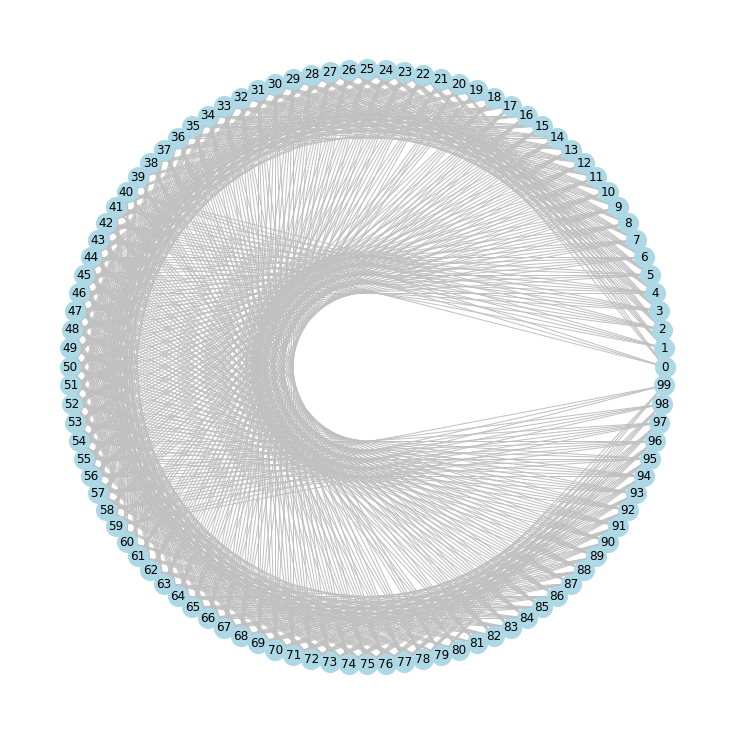

In [12]:
matrix_A = convert_to_csr(matrix_3a[:100, :100])
elim_graph = elimination_graph_csr(matrix_A)
pos = nx.circular_layout(elim_graph)
draw_graph(elim_graph, pos)

"2b. Proszę uruchomić eliminację na tym grafie G0 i narysować nowe
krawędzie w G0"

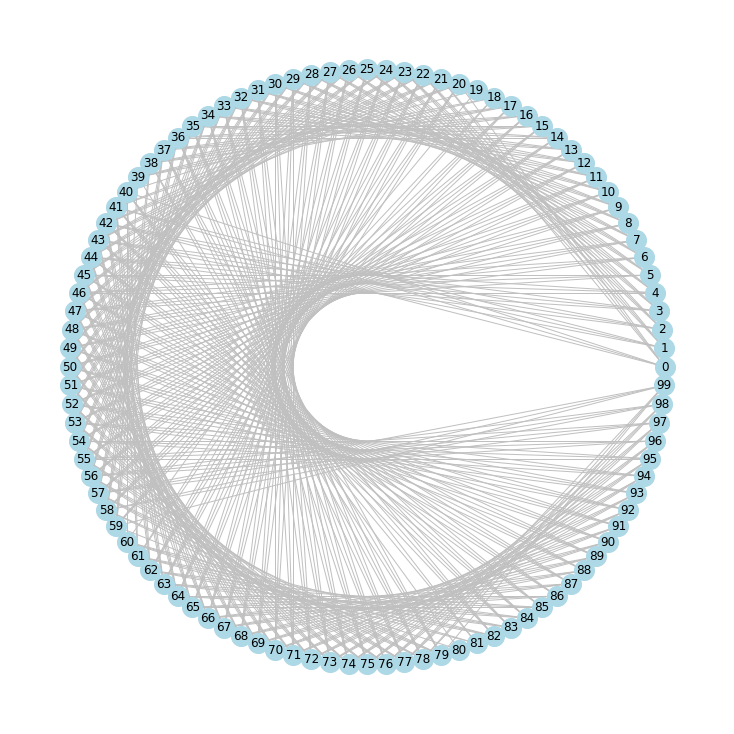

In [13]:
new_elim_graph = elimination_graph_csr(sparse_cholesky(matrix_A))
draw_graph(new_elim_graph, pos)

## Algorytm permutacji macierzy

"3. Proszę napisać i opisać kod wybranego algorytm permutacji macierzy"

In [14]:
G = elimination_graph_csr(convert_to_csr(test_matrix))

def minimum_degree(G, visited):
    non_visited = [x for x in G.nodes() if not visited[x]]
    return min(non_visited, key=lambda x : G.degree(x))
        
def permutation_vector(G):
    n = G.number_of_nodes()
    queue = []
    visited = [False for x in range(n)]
    ordering = []
    while not all(visited):
        s = minimum_degree(G, visited)
        queue.append(s)
        visited[s] = True
        while queue:
            v = queue.pop(0)
            visited[v] = True
            ordering.append(v)
            for neighbor in sorted(G.neighbors(v), key=lambda x : G.degree(x)):
                if not visited[neighbor]:
                    queue.append(neighbor)
    print("Ordering : ", ordering)
    return ordering

def permutation_matrix(ordering):
    n = len(ordering)
    P = np.zeros((n, n)).astype(np.int32)
    for row, order in enumerate(ordering):
        P[row, order] = 1
    return P
    
    
print(G)
print(G[2])

ordering = permutation_vector(G)
permutation_matrix(ordering)

Graph with 5 nodes and 3 edges
{1: {}}
Ordering :  [4, 2, 1, 0, 3]


array([[0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

"4. Proszę uruchomić macierz permutacji dla macierzy z punktu 2"

"5a. Proszę narysować graf eliminacji G0’ dla spermutowanej małej macierz z
punktu 2"

"5b. Proszę uruchomić eliminację Gaussa na tym grafie G0’ i narysować nowe
krawędzie w G0"

In [15]:
from itertools import chain

def rowptr_from_list(val_list):
    ROWPTR = []
    counter = 0
    for row in val_list:
        ROWPTR.append(counter)
        counter += len(row)
    ROWPTR.append(counter)
    return ROWPTR

def sparse_cholesky_permutation(matrix, permutation):
    '''
        returns L.T matrix in CSR format
        that (L.T.)T @ L.T == matrix
    '''

    ICL = matrix[0][:]
    VAL = matrix[1][:]
    ROWPTR = matrix[2][:]
    
    n = len(ROWPTR) - 1
    
    def get_col_in_row(row, col):
        '''binary search for an index of value col in array row
            if col not in row returns index of the first bigger value than col
            if every value in row is smaller than col then returns None'''
        start = 0
        end = len(row)-1

        while start < end:
            middle = (start+end)//2
            if row[middle] < col:
                start = middle+1
            else:
                end = middle

        if row[start] == col:
            return start
        else:
            if start + 1 < len(row):
                return start + 1
            return None
    
    icl_list = [[] for _ in range(len(permutation))]
    val_list = [[] for _ in range(len(permutation))]
    
    for k_idx, k in enumerate(permutation):
        row_start = ROWPTR[k]
        row_end = ROWPTR[k+1]

        if ICL[row_start] != k or VAL[row_start] < 0:
            print("ICL[{}]={} != {} or VAL[{}]={} < 0".format(row_start, ICL[row_start], k, row_start, VAL[row_start]))
            raise Exception('nonpositive value on diagonal')

        VAL[row_start] **= 0.5
        dkk = VAL[row_start]
        
        for j in range(row_start+ 1, row_end):
            VAL[j] /= dkk

        icl_list[k] = ICL[row_start:row_end]
        val_list[k] = VAL[row_start:row_end]
        for k_non_visited in permutation[k_idx + 1:]:
            icl_list[k_non_visited] = []
            val_list[k_non_visited] = []

        
        # last row -> nothing to eliminate
        if k == permutation[-1]:
            break
            
        vk_index = row_start + 1

        for j in permutation[k_idx + 1:]:
            # top_row = kth_row (not always 0th row!)
            # j_row = jth_row
            # we aim to calculate:  j_row = j_row - top_row*vk
            j_row_start = ROWPTR[j]
            j_row_end = ROWPTR[j+1]

            # we find indices in top_row ICL and j_row ICL on which value j is,
            # so we can start eliminating from there
            j_index_j_row = get_col_in_row(ICL[j_row_start:j_row_end], j)
            j_index_top_row = get_col_in_row(ICL[row_start:row_end], j)

            # if vk is 0, we just copy j_row from jth index and continue to the next row
            if vk_index >= row_end or ICL[vk_index] != j:
                if j_index_j_row is not None:
                    icl_list[j] += ICL[j_row_start+j_index_j_row:j_row_end]
                    val_list[j] += VAL[j_row_start+j_index_j_row:j_row_end]
                continue

            vk = VAL[vk_index]

            # if both top row and jth row are empty after jth index, we move onto the next row
            if j_index_j_row is None and j_index_top_row is None:
                continue

            # if jth row is empty after jth index we copy -vk*top_row
            if j_index_j_row is None:
                icl_list[j] += ICL[row_start + j_index_top_row:row_end]
                val_list[j] += [-vk*x for x in VAL[row_start +
                                               j_index_top_row:row_end]]
                continue
            else:
                 j_row_index = j_row_start + j_index_j_row

            # if top row is empty after jth index we just copy jth row as it is
            if j_index_top_row is None:
                icl_list[j] += ICL[j_row_index:j_row_end]
                val_list[j] += VAL[j_row_index:j_row_end]
                continue
            else:
                top_row_index = row_start + j_index_top_row


            # we iterate through top_row and j_row at the same time
            # doing the elimination
            # new non-zero values may occur
            while j_row_index < j_row_end and top_row_index < row_end:
                top_col = ICL[top_row_index]
                j_col = ICL[j_row_index]

                # nonzero value in kth row, zero in jth
                # new nonzero value
                if top_col < j_col:
                    val = -vk*VAL[top_row_index]
                    if abs(val) > 1e-8:
                        icl_list[j].append(top_col)
                        val_list[j].append(val)   
                    top_row_index += 1

                # both values nonzero
                elif top_col == j_col:
                    val = VAL[j_row_index]-vk*VAL[top_row_index]
                    if abs(val) > 1e-8:
                        icl_list[j].append(top_col)
                        val_list[j].append(val)   
                    top_row_index += 1
                    j_row_index += 1

                # nonzero in jth row, but zero in k
                elif top_col > j_col:
                    icl_list[j].append(j_col)
                    val_list[j].append(VAL[j_row_index])      
                    j_row_index += 1

            # there might still be nonzero values in jth row
            # and just zeros in kth
            while j_row_index < j_row_end:
                icl_list[j].append(ICL[j_row_index])
                val_list[j].append(VAL[j_row_index]) 
                j_row_index += 1

            # there might still be nonzero values in kth row
            # and just zeros in jth
            while top_row_index < row_end:
                val = -vk*VAL[top_row_index]
                if abs(val) > 1e-8:
                    icl_list[j].append(ICL[top_row_index])
                    val_list[j].append(val) 
                top_row_index += 1

            if vk_index < row_end and ICL[vk_index] == j:
                vk_index += 1
        
        
        ROWPTR = rowptr_from_list(val_list)
        ICL = list(chain.from_iterable(icl_list))
        VAL = list(chain.from_iterable(val_list))

    return ICL, VAL, ROWPTR

def get_matrix_from_CSR(A):
    ICL, VAL, ROWPTR = A
    VAL = VAL.copy()
    
    n = len(ROWPTR) - 1
    matrix = np.zeros((n, n))

    for row in range(n):
        for j in range(ROWPTR[row], ROWPTR[row+1]):
            matrix[row, ICL[j]] = VAL[j]
            
    return matrix

In [16]:
def get_ICL_VAL_from_dict(C_ROW):
    C_ROW_sorted = sorted(C_ROW.items(), key=lambda item : item[0]) # sorting by key (column index)
    ICL_C = [x[0] for x in C_ROW_sorted] # column indexes list
    VAL_C = [x[1] for x in C_ROW_sorted] # values list
    return ICL_C, VAL_C
    
def matmul_CSR(A, B):
    ICL_A, VAL_A, ROWPTR_A = A
    ICL_B, VAL_B, ROWPTR_B = B    
    ICL_C, VAL_C, ROWPTR_C = [], [], []

    elements_counter = 0
    for i in range(len(ROWPTR_A) - 1): # rows in A
        row_a_start_idx = ROWPTR_A[i]
        row_a_end_idx = ROWPTR_A[i+1]
        C_ROW = dict() # dict to store results of row_A * rows_B
        for j in range(row_a_start_idx,row_a_end_idx): # indexes of values in row A
            col_a = ICL_A[j]
            val_a = VAL_A[j]
            row_b_start_idx = ROWPTR_B[col_a] # column idx in A maps to row idx in B
            row_b_end_idx = ROWPTR_B[col_a + 1] # col_a + 1 to get range of value indexes in B row
            for p in range(row_b_start_idx,row_b_end_idx): # indexes of values in row B
                col_b = ICL_B[p]
                val_b = VAL_B[p]
                C_ROW[col_b] = C_ROW.get(col_b, 0) + (val_a * val_b) # update dict with val_a * val_b
                
        ICL, VAL = get_ICL_VAL_from_dict(C_ROW)
        ICL_C += ICL
        VAL_C += VAL
        ROWPTR_C.append(elements_counter)
        elements_counter += len(VAL)
    
    ROWPTR_C.append(elements_counter)
    return ICL_C, VAL_C, ROWPTR_C

P = permutation_matrix(ordering)
P_T = P.T
print(P)
print(P_T)



[[0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]
[[0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


In [18]:
test_matrix_csr = convert_to_csr(test_matrix)
print("P : \n", P)
P_csr = convert_to_csr(P)
P_T_csr = convert_to_csr(P_T)
test_matrix_permutated_csr = matmul_CSR(matmul_CSR(P_csr, test_matrix_csr), P_T_csr)
print("P * A * P.T\n", get_matrix_from_CSR(test_matrix_permutated_csr))

sparse_lt = sparse_cholesky(test_matrix_csr)
dense_result = get_matrix_from_CSR(sparse_lt)

print('\nL.T obliczone funkcją dla macierzy rzadkich: ')
print(dense_result)


sparse_lt = sparse_cholesky(test_matrix_permutated_csr)
dense_result = get_matrix_from_CSR(sparse_lt)

print('\nL.T obliczone funkcją dla macierzy rzadkich z macierzą permutacji: ')
print(dense_result)

sparse_lt = sparse_cholesky_permutation(test_matrix_csr, permutation_vector(elimination_graph_csr(test_matrix_csr)))
dense_result = get_matrix_from_CSR(sparse_lt)

print('\nL.T obliczone funkcją dla macierzy rzadkich z wektorem permutacji: ')
print(dense_result)

P : 
 [[0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]
P * A * P.T
 [[5. 0. 0. 0. 0.]
 [0. 3. 1. 0. 0.]
 [0. 1. 2. 1. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 4.]]

L.T obliczone funkcją dla macierzy rzadkich: 
[[ 1.          1.          0.          1.          0.        ]
 [ 0.          1.          1.         -1.          0.        ]
 [ 0.          0.          1.41421356  0.70710678  0.        ]
 [ 0.          0.          0.          1.22474487  0.        ]
 [ 0.          0.          0.          0.          2.23606798]]

L.T obliczone funkcją dla macierzy rzadkich z macierzą permutacji: 
[[2.23606798 0.         0.         0.         0.        ]
 [0.         1.73205081 0.57735027 0.         0.        ]
 [0.         0.         1.29099445 0.77459667 0.        ]
 [0.         0.         0.         0.63245553 1.58113883]
 [0.         0.         0.         0.         1.22474487]]
Ordering :  [4, 2, 1, 0, 3]

L.T obliczone funkcją dla macierzy rzadkich z wektorem permutacji: 
[[1.

"6. Proszę uruchomić swój algorytm permutacji dla całej dużej (rozmiar > 100)
macierzy z zadania 4"

## Porównanie czasów

"7. Proszę porównać czasy rzadkiej eliminacji Gaussa przed permutacją i po
permutacji dla dużej macierzy (rozmiar > 100)"

## Wnioski

* 
* 

M. Hawryluk, N. Wolniak. 2022